## Introduction to SNT Programming

This notebook provides an overview on scripting the [SNT](https://imagej.net/SNT) [API](https://morphonets.github.io/SNT/) from Python. Before starting, we need to make  SNT accessible from this notebook through [pyimagej](https://pypi.org/project/pyimagej/). If you haven't done so, have a look at the [detailed instructions](./README.md) on how to set up your environment.

Let's get started! Once installed, `imagej` is imported as any other module:

In [1]:
import os
import sys
import imagej

Next, we must initialize ImageJ within the notebook environment. Initialization can be done with GUI support or in headless mode. There are two ways to accomplish this:
1. Specifying a remote path for Fiji. This allows, e.g., for the direct execution on [Binder](https://mybinder.org/v2/gh/morphonets/SNT/master?filepath=%2Fnotebooks%2F1_overview.ipynb) (no local files are required) but the installation times are prohibitively long.
2. Specifying a local Fiji installation (subscribed to the NeuroAnatomy update site). This is significantly faster, and  the preferred way. As mentioned [earlier](./README.md), [ijfinder.py](ijfinder.py) can be used to streamline this task. Simply [insert](ijfinder.py) the absolute path to your _Fiji.app_ directory under `local_fiji_dir`, and its location will be shared across all of SNT notebooks in this collection. If the directory is not found, the script will prompt you for an alternative:

In [2]:
import os
import sys
import imagej
import ijfinder

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

As would be done in a Jython script using Fiji's Script Editor, we need to import the SNT classes we want to use. This is done using [pyjnius](https://pyjnius.readthedocs.io/en/stable/). Note that we must import `jnius` _AFTER_ ImageJ (Fiji) is initialized.

In [3]:
from jnius import autoclass, cast
SNTUtils = autoclass('sc.fiji.snt.SNTUtils')
print("We are running SNT %s" % SNTUtils.VERSION)

We are running SNT 3.1.102-SNAPSHOT


## Loading a Tree

Let's load a neuron (a [Tree](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/Tree.html)) from the [MouseLight database](http://ml-neuronbrowser.janelia.org/). We will be using the [Scijava](https://javadoc.scijava.org/) and [SNT](https://morphonets.github.io/SNT/) APIs frequently. The most up-to-date SNT API is found at https://morphonets.github.io/SNT/. After skimming through it, we know that, e.g., we can use 
[MouseLightLoader](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/io/MouseLightLoader.html):

In [4]:
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')

Now we can access all the attributes and methods this class offers. Let's load a specific mouse cortical motor neuron (ID = "AA0100" in the [MouseLight database](http://ml-neuronbrowser.janelia.org/)). First, we initialize ```MouseLightLoader``` with the ID String of the desired reconstruction. The loader object has methods to check database availability and validity of passed IDs:

In [5]:
loader = MouseLightLoader("AA0100")
if not loader.isDatabaseAvailable():
    print("Could not connect to ML database", "Error")
if not loader.idExists():
    print("Somehow the specified id was not found", "Error")

To extract a specific neurite compartment from the loader object as a [Tree](https://morphonets.github.io/SNT/sc/fiji/snt/Tree.html), we can call ```loader.getTree(compartment_string)```
where compartment_string may be - 'soma', 'axon', 'dendrite', or 'all' (case insensitive). Leaving the argument empty will return all compartments.

In [6]:
axon = loader.getTree('axon')

Let's visualize the axonal Tree. SNT offers a handful of [dedicated viewers](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/Tree.html) for both single cells and cell groups. [Viewer2D](https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Viewer2D.html) (_Reconstruction Plotter_) and [Viewer3D](https://morphonets.github.io/SNT/sc/fiji/snt/viewer/Viewer3D.html) (_Reconstruction Viewer_) are the most frequently used. By calling `show()`, SNT will automatically choose a suitable viewer, but we can impose the display of 2D projection of the reconstruction by calling `show2D()`:

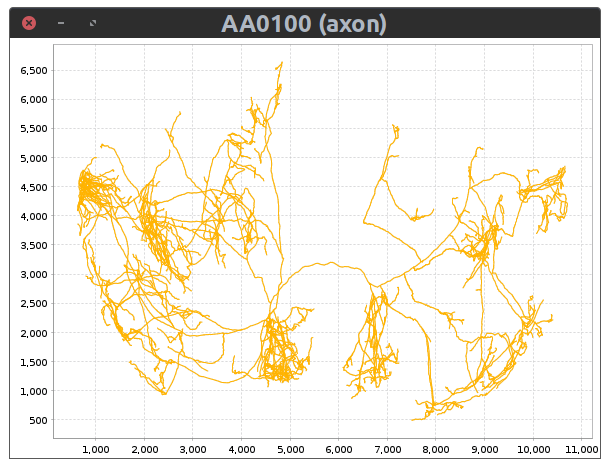

In [7]:
axon.show2D()

#from IPython.display import Image, display
#display(Image(filename=r"./images/AA0100plotter.png",  width=500))

To visualize the cell in 3D we can use `show3D()`, to display the axon on a interactive 3D canvas. But if we want the enriched experience of a standalone [Reconstruction Viewer](https://imagej.net/SNT:_Reconstruction_Viewer) we need to pass a [SciJava Context](https://javadoc.scijava.org/SciJava/org/scijava/Context.html) Class to the Viewer's constructor:

In [8]:
Context = autoclass('org.scijava.Context')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')
viewer_3d = Viewer3D(Context())

Now, we can enrich the scene, and use the GUI controls of the Viewer to import, manage and customize the Viewer's scene:

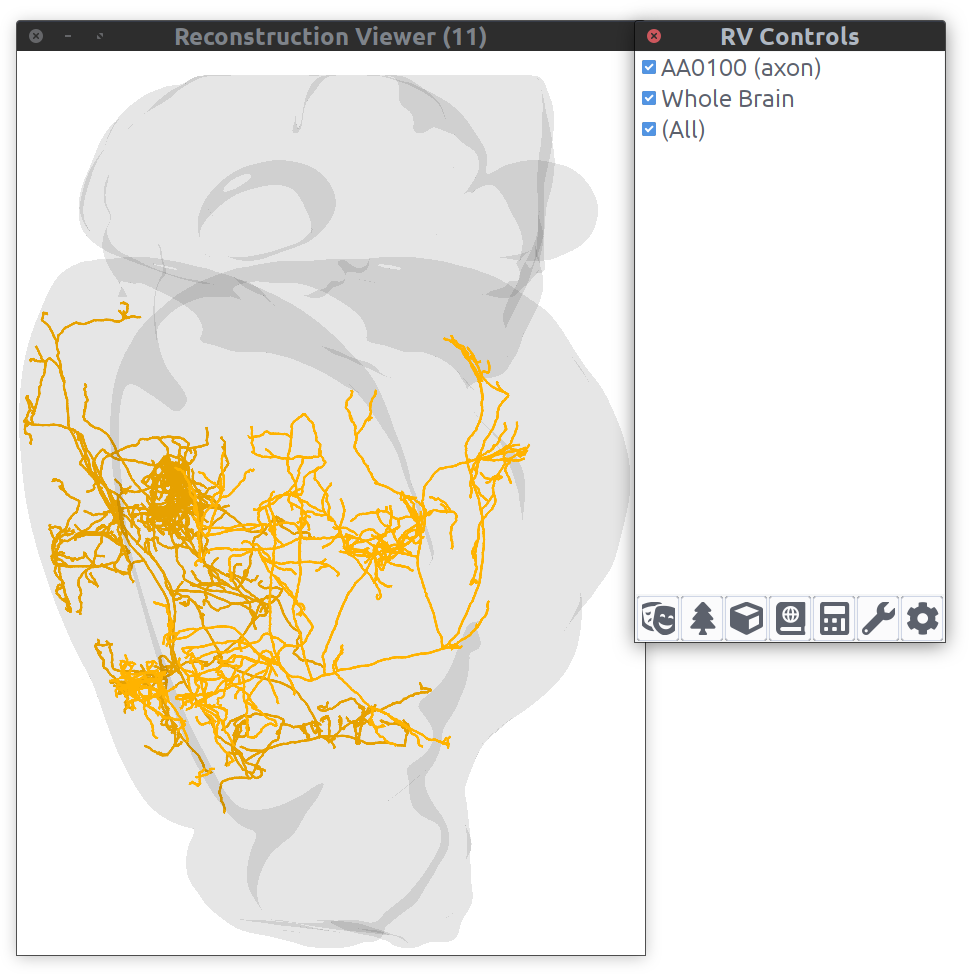

In [9]:
viewer_3d.setEnableDarkMode(False)
viewer_3d.add(axon)
viewer_3d.loadRefBrain('mouse')
viewer_3d.setViewMode('sagittal')
viewer_3d.setAnimationEnabled(True)
viewer_3d.show()

#from IPython.display import Image, display
#display(Image(filename=r"./images/AA0100viewer.png",  width=650))

We can also retrieve a skeletonized mask (2D or 3D) of a Tree:

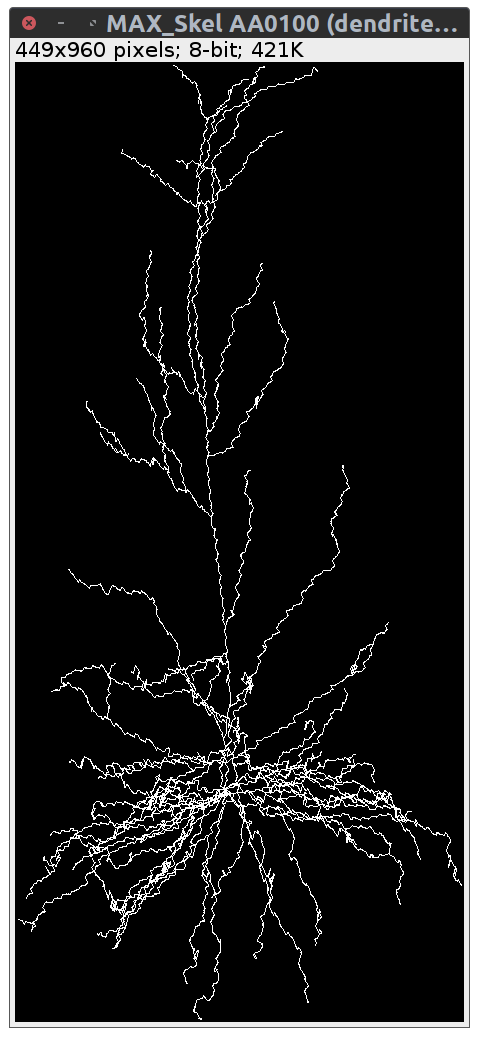

In [10]:
dendrites = loader.getTree('dendrites')
dendrites.getSkeleton2D().show()

#from IPython.display import Image, display
#display(Image(filename=r"./images/AA0100skel2d.png",  width=300))

[Convertion to ROIs](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/RoiConverter.html) is also possible.

## Measuring a Tree

Most simply, a Tree can be measured using [TreeAnalyzer](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/TreeAnalyzer.html) and its extending class [TreeStatistics](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/TreeAnalyzer.html) (other classes in the [analysis package](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/package-summary.html) provide further functionality). We can construct an instance of `TreeStatistics` class using the axon `Tree`:

In [11]:
TreeStatistics = autoclass('sc.fiji.snt.analysis.TreeStatistics')
t_stats = TreeStatistics(axon)

Both [TreeAnalyzer](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/TreeAnalyzer.html) and [TreeStatistics](https://morphonets.github.io/SNT/index.html?sc/fiji/snt/analysis/TreeAnalyzer.html):
provide a variety of metrics with which to measure reconstructions: The former will tipically retrieve single  value measurements: e.g. `getCableLength()` while the latter extends TreeAnalyzer to allow access to distribution statistics.

To see the full list of supported metrics, we can use `getAllMetrics()`. Importantly, the Object returned by this method is a [Java List](https://javadoc.scijava.org/Java8/index.html?java/util/List.html), and should be converted to the equivalent Python representation before attempting to iterate over it. We can do this using pyimagej's `ij.py.from_java()` method:

In [12]:
ta_metrics = ij.py.from_java(t_stats.getAnalyzerMetrics())
ts_metrics = ij.py.from_java(t_stats.getAllMetrics())

print("\nTreeAnalyzer metrics:")
print(*ta_metrics, sep = ", ")
print("\nTreeStatistics metrics:")
print(*ts_metrics, sep = ", ")


TreeAnalyzer metrics:
Assigned value, Average branch length, Average contraction, Depth, Height, Highest path order, Cable length, Mean radius, No. of branch points, No. of branches, No. of fitted paths, No. of nodes, No. of paths, No. of primary branches, No. of terminal branches, No. of tips, Length of primary branches (sum), Horton-Strahler number, Horton-Strahler bifurcation ratio, Length of terminal branches (sum), Width

TreeStatistics metrics:
Branch length, Contraction, Inter-node distance, Inter-node distance (squared), Path mean radius, No. of branch points, No. of nodes, Node radius, Path length, Path order, Length of primary branches, Length of terminal branches, Node intensity values, X coordinates, Y coordinates, Z coordinates


These metrics can be used to retrieve computations, distributions, etc. Here is an example:

In [13]:
metric = "Inter-node dx" #fuzzy matching is supported so we can abbreviate distance
summary_stats = t_stats.getSummaryStats(metric)
print("The average inter-node distance is %d micrometers" % summary_stats.getMean())
print("The standard deviation is %d" % summary_stats.getStandardDeviation())

The average inter-node distance is 21 micrometers
The standard deviation is 12


We can also plot histograms directly:

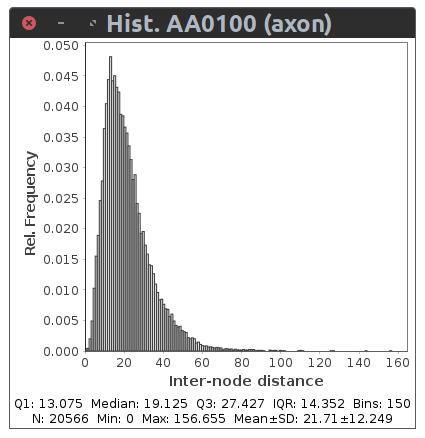

In [14]:
t_stats.getHistogram(metric).show()

#from IPython.display import Image, display
#display(Image(filename=r"./images/AA0100hist.png",  width=400))

Since TreeStatistics extends TreeAnalyzer, we can also access all of TreeAnalyzer's functionality from the `t_stats` instance:

In [15]:
print("The cable length of the axon is %d micrometers" % t_stats.getCableLength())

The cable length of the axon is 446486 micrometers


## Accessing Neuropil Annotations

Where does this axon project to? TreeStatistics is also aware of the location of each node in the brain. So we can, e.g., find out cable length is distributed across brain regions. For clarity, we will focus on brain regions of a specific (mid) ontology level of the [Allen Brain Atlas](http://mouse.brain-map.org/):

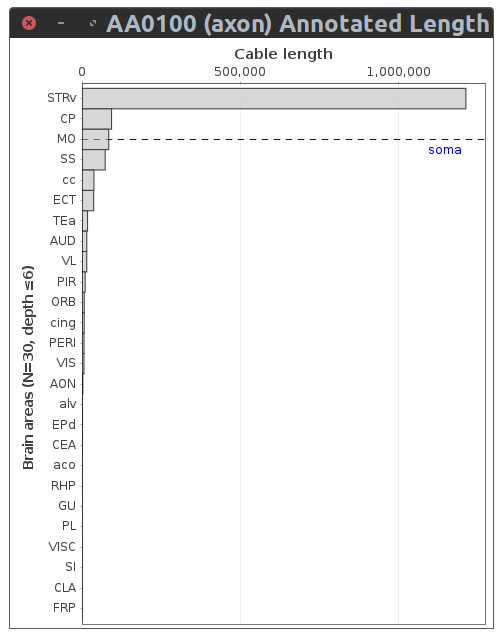

In [16]:
t_stats.getAnnotatedLengthHistogram(6).show()

#from IPython.display import Image, display
#display(Image(filename=r"./images/AA0100annot.png",  width=400))

Have a look at remaining [notebooks](./) for further examples.